rfBORG - Resistance is futile!

In [1]:
import os
from pynq import Overlay
import xrfclk
import numpy as np
from pynq import Xlnk
from pynq import Overlay
import matplotlib.pyplot as plt
import ipywidgets as ipw
from ipywidgets import interact, interactive, fixed, interact_manual
import struct

In [2]:
from time import sleep
from matplotlib import pyplot as plt

In [3]:
# upload firmware and load module drivers
firmware = Overlay('bram_lutwave2.bit')

In [4]:
# start RF Data Converter
fsamp = 409.6 # MHz
print(xrfclk.get_freq_list())
xrfclk.set_all_ref_clks(fsamp)

dict_keys([102.4, 204.8, 409.6, 737])


In [5]:
mux = firmware.AXI_mux_0 # When 1 pass counter, when 0 pass bram address
bram = firmware.bram_interface_0

In [19]:
# Load BRAM with I0, I1 waveform
data_p = 2**21 # length of timestream or length of LUT
fs = 512.0e6 # sampling rate of D/A, FPGA fabric = fs/2
#fs = 500.6221109728642e6 # knowing that PLL ref freq for PYNQ != PLL ref freq of RF DATA CONV.
# f = lambda x :  int(x*data_p/fs)*(fs/data_p)
# f0 = f(125e6) # actual tone frequency in Hz

freqs = np.linspace(1e6,255e6,500)
#freqs = np.array((50e6,50e6)) # desired frequencies in Hz
A = 2**15-1 # 16 bit D/A, expecting unsigned values.
freq_res = fs/data_p # Hz

print(freqs)
# Trial 1
# determine fft bin
freqs = np.round(freqs/(freq_res))*freq_res
print(freqs)
delta = np.zeros(data_p,dtype="complex") # empty array of deltas
for i in range(len(freqs)):
    bin_num = np.round((freqs[i]/freq_res)).astype('int')
    delta[bin_num] = 1.0

ts = np.fft.ifft(delta,norm="ortho")
ts_norm = (ts.real/max(ts.real)*A).astype("int") # also not signed values
I0 = ts_norm.real[0::2]
I1 = ts_norm.real[1::2]
# normalize
# I0_norm = (I0/max(I0)*A).astype("int")
# I1_norm = (I1/max(I0)*A).astype("int")
Z = (I1 << 16) + I0 # this is the correct order (I1<<16) + I0 !
I_lut = np.array(Z)

# I_lut=((I0_norm<<16)+I1_norm)


"""
# from kidPy
freqs = np.round(freqs/self.dac_freq_res)*self.dac_freq_res
309         amp_full_scale = (2**15 - 1)
310         if DAC_LUT:
311             fft_len = self.LUTbuffer_len
312             k = self.fft_bin_index(freqs, fft_len, samp_freq)
313             if random_phase == True:
314                 np.random.seed()
315                 phase = np.random.uniform(0., 2.*np.pi, len(k))
316             if apply_transfunc:
317                 print "Applying transfer function to DAC LUTS"
318                 self.amps = self.get_transfunc()
319             else:
320                 self.amps = np.array([1.]*len(k))
321                 #wn = np.load('noise_tf.npy')
322                 #self.amps = np.mean(wn)/wn
323             spec = np.zeros(fft_len,dtype='complex')
324             spec[k] = self.amps*np.exp(1j*(phase))
325             wave = np.fft.ifft(spec)
326             waveMax = np.max(np.abs(wave))
327             I = (wave.real/waveMax)*(amp_full_scale)
328             Q = (wave.imag/waveMax)*(amp_full_scale)
"""

"""
#Trial 2
x=np.linspace(0,data_p,data_p)
I0 = (A*np.sin((fs/4)*2*np.pi*x[0::2]) + A).astype("uint32")
I1 = (A*np.sin((fs/5)*2*np.pi*x[1::2]) + A).astype("uint32")
I_lut= (I1<<16)+I0
"""
"""
n=8
x=np.linspace(0,n,n)
I0 = (A*np.sin(2*np.pi*x[0::2]/n) + A).astype("uint32")
I1 = (A*np.sin(2*np.pi*x[1::2]/n) + A).astype("uint32")
I_lut= (I1<<16)+I0
I_lut=np.repeat(I_lut,data_p//4)
"""

"""
#####################################################
# Concatenate I0 and I1 # FS/4 sinewave works
#####################################################
x=np.array((0, A-1, 0, -A)) #+ A
y=x*A//max(x)
Z = [(y[0]<<16)+y[1],(y[2]<<16)+y[3]]*(data_p//4)
I_lut=np.array(Z)
#####################################################
# array([ 32768, -32770,  32768, ..., -32770,  32768, -32770])
"""

"""
I_lut = np.zeros(data_p//2).astype("uint32")
for i in range(data_p//2):
  a = I1[i]<<16
  b = I0[i]
  I_lut[i] = a + b
"""

[  1.00000000e+06   1.25425425e+06   1.50850851e+06   1.76276276e+06
   2.01701702e+06   2.27127127e+06   2.52552553e+06   2.77977978e+06
   3.03403403e+06   3.28828829e+06   3.54254254e+06   3.79679680e+06
   4.05105105e+06   4.30530531e+06   4.55955956e+06   4.81381381e+06
   5.06806807e+06   5.32232232e+06   5.57657658e+06   5.83083083e+06
   6.08508509e+06   6.33933934e+06   6.59359359e+06   6.84784785e+06
   7.10210210e+06   7.35635636e+06   7.61061061e+06   7.86486486e+06
   8.11911912e+06   8.37337337e+06   8.62762763e+06   8.88188188e+06
   9.13613614e+06   9.39039039e+06   9.64464464e+06   9.89889890e+06
   1.01531532e+07   1.04074074e+07   1.06616617e+07   1.09159159e+07
   1.11701702e+07   1.14244244e+07   1.16786787e+07   1.19329329e+07
   1.21871872e+07   1.24414414e+07   1.26956957e+07   1.29499499e+07
   1.32042042e+07   1.34584585e+07   1.37127127e+07   1.39669670e+07
   1.42212212e+07   1.44754755e+07   1.47297297e+07   1.49839840e+07
   1.52382382e+07   1.54924925e+07

'\nI_lut = np.zeros(data_p//2).astype("uint32")\nfor i in range(data_p//2):\n  a = I1[i]<<16\n  b = I0[i]\n  I_lut[i] = a + b\n'

In [18]:
max(I0)

32689

In [64]:
fs/5

100000000.0

<IPython.core.display.Javascript object>


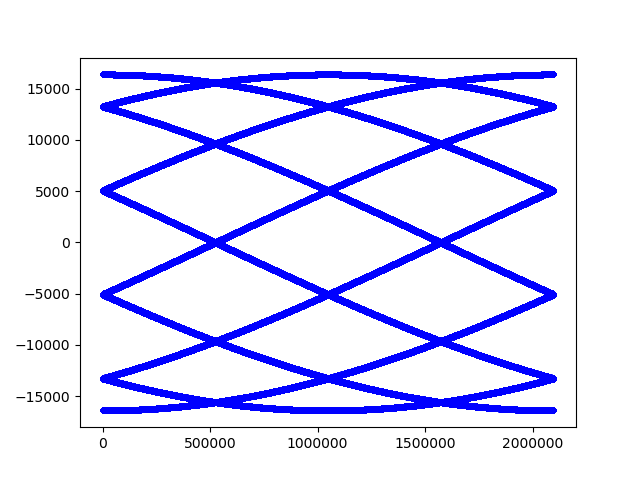

In [93]:
%matplotlib notebook
plt.figure()
plt.plot(ts_norm,'b.')
plt.show()

In [ ]:
type(I_lut[1])

In [20]:
# write I_lut to BRAM
# make sure address mux is on bram pass through
c=0
mux.write(0,c) # pass 
bram.write(8,0) # write enable to false
bram.write(12,0) # disnable bram
bram.write(12,1) # enable bram
for i in range(data_p//2):
    if i%100000 == 0:
      print("addr: "+str(i) +" val: "+ str(I_lut[i]))   
    #bram.write(8,0) # write enable to false to enable reading
    bram.write(4,int(I_lut[i])) # write data value
    bram.write(0,i) # write address
    bram.write(8,1) # write enable to true save value to address
    bram.write(8,0) # write enable to false to enable reading
print("Ready!")
#bram.write(8,0)

addr: 0 val: 32767
addr: 100000 val: 10
addr: 200000 val: -112
addr: 300000 val: -109
addr: 400000 val: 0
addr: 500000 val: 132
addr: 600000 val: 24
addr: 700000 val: -28
addr: 800000 val: 61
addr: 900000 val: -133
addr: 1000000 val: 25
Ready!


In [21]:
# 1 to enable the cyclic read address counter
c = ~c
mux.write(0,abs(c))

In [ ]:
mux.write(0,0)

In [ ]:
x=np.array((0, A-1, 0, -A)) + A
y=x*A//max(x)
Z = [(y[0]<<16)+y[1],(y[2]<<16)+y[3]]*(data_p//2)
I_lut=np.array(Z)

In [ ]:
#2**4-1 & 0xFFFFFFFF
for i in range(len(I_lut)):
    if ((I_lut[i] / (I_lut[i] & 0xFFFFFFFF)) != 1):
        print("1")

In [ ]:
for i in range(int(data_p/2)):
    print("LUT- {} \t BRAM- {}".format(I_lut[i], bram.read(i)))

<IPython.core.display.Javascript object>


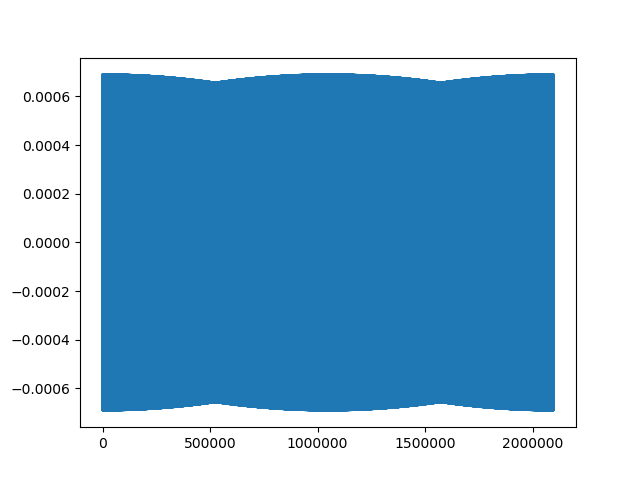

In [54]:
plt.figure()
plt.plot(ts.real)
plt.show()

0.00069053396600248776